# Constants

In [1]:
IALAB_USER = 'jiossandon'

# Imports

In [2]:
import os
import os.path as osp
import json
import sys

In [13]:
print(sys.path)

['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/jiossandon/.local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/home/jiossandon/.local/lib/python3.6/site-packages/IPython/extensions', '/mnt-homes/kraken/jiossandon/.ipython', '/home/jiossandon/datasets/Matterport3DSimulator/build', '/home/jiossandon/storage/360-visualization/metadata_parser', '/home/jiossandon/storage/speaker_follower_with_objects/tasks/R2R/speaker/results/', 'build/']


In [17]:
matterport_build_path = f'/home/{IALAB_USER}/datasets/Matterport3DSimulator/build'
metadata_script_path = f'/home/{IALAB_USER}/repos/360-visualization/metadata_parser'
results_path = f'/home/{IALAB_USER}/storage/speaker_follower_with_objects/tasks/R2R/speaker/results/'

In [18]:
if matterport_build_path not in sys.path:
    sys.path.append(matterport_build_path)

if metadata_script_path not in sys.path:
    sys.path.append(metadata_script_path)
    
if results_path not in sys.path:
    sys.path.append(results_path)

In [19]:
import json
import sys
sys.path.append('build/')
import MatterSim
import time
import numpy as np
import skimage.transform
import networkx as nx

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from parse_house_segmentations import HouseSegmentationFile

# Simulator

In [ ]:
# load navigation graph to calculate the relative heading of the next location
def load_nav_graph(graph_path):
    with open(graph_path) as f:
        G = nx.Graph()
        positions = {}
        data = json.load(f)
        for i,item in enumerate(data):
            if item['included']:
                for j,conn in enumerate(item['unobstructed']):
                    if conn and data[j]['included']:
                        positions[item['image_id']] = np.array([item['pose'][3], 
                                item['pose'][7], item['pose'][11]]);
                        assert data[j]['unobstructed'][i], 'Graph should be undirected'
                        G.add_edge(item['image_id'],data[j]['image_id'])
        nx.set_node_attributes(G, values=positions, name='position')
    return G

def compute_rel_heading(graph, current_viewpoint, current_heading, next_viewpoint):
    if current_viewpoint == next_viewpoint:
        return 0.
    target_rel = graph.nodes[next_viewpoint]['position'] - graph.nodes[current_viewpoint]['position']
    target_heading = np.pi/2.0 - np.arctan2(target_rel[1], target_rel[0]) # convert to rel to y axis
    
    rel_heading = target_heading - current_heading

    # normalize angle into turn into [-pi, pi]
    rel_heading = rel_heading - (2*np.pi) * np.floor((rel_heading + np.pi) / (2*np.pi))
    return rel_heading

In [ ]:
def visualize_panorama_img(scan, viewpoint, heading, elevation):
    WIDTH = 80
    HEIGHT = 480
    pano_img = np.zeros((HEIGHT, WIDTH*36, 3), np.uint8)
    VFOV = np.radians(55)
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(VFOV)
    sim.initialize()
    for n_angle, angle in enumerate(range(-175, 180, 10)):
        sim.newEpisode([scan], [viewpoint], [heading + np.radians(angle)], [elevation])
        state = sim.getState()
        im = state[0].rgb
        im = np.array(im)
        pano_img[:, WIDTH*n_angle:WIDTH*(n_angle+1), :] = im[..., ::-1]
    return pano_img

def visualize_tunnel_img(scan, viewpoint, heading, elevation):
    WIDTH = 640
    HEIGHT = 480
    VFOV = np.radians(60)
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(VFOV)
    sim.init()
    sim.newEpisode(scan, viewpoint, heading, elevation)
    state = sim.getState()
    im = state.rgb
    return im[..., ::-1].copy()

## Initialize data for after processing

In [ ]:
from collections import defaultdict

viewpoints_information = defaultdict(dict)

# Visualization

In [ ]:
LABEL_MAPPING = {
    'a': 'bathroom',
    'b': 'bedroom',
    'c': 'closet',
    'd': 'dining room',
    'e': 'entryway/foyer/lobby',
    'f': 'familyroom',
    'g': 'garage',
    'h': 'hallway',
    'i': 'library',
    'j': 'laundryroom/mudroom',
    'k': 'kitchen',
    'l': 'living room',
    'm': 'meetingroom/conferenceroom',
    'n': 'lounge',
    'o': 'office',
    'p': 'porch/terrace/deck/driveway',
    'r': 'rec/game',
    's': 'stairs',
    't': 'toilet',
    'u': 'utilityroom/toolroom',
    'v': 'tv',
    'w': 'workout/gym/exercise',
    'x': 'outdoor areas containing grass, plants, bushes, trees, etc.',
    'y': 'balcony',
    'z': 'other room',
    'B': 'bar',
    'C': 'classroom',
    'D': 'dining booth',
    'S': 'spa/sauna',
    'Z': 'junk',
    '-': 'no label'
}

def get_viewpoint_region_name(metadata, viewpoint):
    values = metadata.get_region(viewpoint).label.values
    if not values.size > 0:
        return 'no label'
    label_keyword = values[0]
    return LABEL_MAPPING[label_keyword]

In [ ]:
import matplotlib.patches as patches

IMG_HEIGHT = 1440
IMG_WIDTH = 2880

def get_info(scan, viewpoint, viewpoint_heading, next_viewpoint, metadata, viewpoints_information, visualize=True):
    objects = metadata.angle_relative_viewpoint_objects(viewpoint)
    
    # Add to post processing data
    viewpoints_information[viewpoint]['objects'] = []
    viewpoints_information[viewpoint]['viewpoints'] = []

    connectivity_path = f'/home/{IALAB_USER}/repos/360-visualization/connectivity/{scan}_connectivity.json'
    reachable_viewpoints = metadata.angle_relative_reachable_viewpoints(viewpoint, connectivity_path)
    
    if visualize:
        images = []
        for viewpoint_elevation in (np.pi / 2 * x for x in range(-1, 2)):
            im = visualize_panorama_img(scan, viewpoint, viewpoint_heading, viewpoint_elevation)
            images.append(im)

        fig, ax = plt.subplots(1,1, figsize=(18,9))

        img = np.concatenate(images[::-1], axis=0)

        ax.imshow(img)
        plt.xticks(np.linspace(0, IMG_WIDTH - 1, 5), [-180, -90, 0, 90, 180])
        plt.xlabel(f'relative heading from the agent. -90° is left, 90° is right, and (-)180° is behind')
        plt.yticks(np.linspace(0, IMG_HEIGHT - 1, 5), [-180, -90, 0, 90, 180])
    
    next_heading = viewpoint_heading
    x0, y0 = viewpoint_heading, 0
    for obj in objects.itertuples():
        heading, elevation = float(obj.heading), float(obj.elevation)
        category = obj.category_mapping_name
        
        if any(word in category for word in ['roof', 'floor', 'ceiling', 'unknown', 'wall', 'door', 'rug', 'otherroom', 'frame']):
            continue

        heading -= x0
        while heading > np.pi:
            heading -= 2 * np.pi
        while heading < -np.pi:
            heading += 2 * np.pi

        elevation += y0
        while elevation > np.pi:
            heading -= 2 * np.pi
        while elevation < -np.pi:
            elevation += 2 * np.pi

        first_coord = (heading / (2 * np.pi) + 0.5) * IMG_WIDTH
        second_coord = (0.5 - elevation / (np.pi / 1.1)) * IMG_HEIGHT
        
        CONST = 300 * 1/obj.distance * 3
        
        # Add to post processing data
        viewpoints_information[viewpoint]['objects'].append(
            [
                category, 
                first_coord / IMG_WIDTH * 2 * np.pi,
                obj.distance,
                (obj.r0, obj.r1, obj.r2),
                float(obj.r1) * CONST * float(obj.r0) * CONST
            ]
        )
        
        if visualize:
            first_pos = first_coord - float(obj.r1) * CONST / 2
            second_pos = second_coord - float(obj.r0) * CONST / 2
            rect = patches.Rectangle((first_pos, second_pos), float(obj.r1) * CONST, float(obj.r0) * CONST, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(first_coord, second_coord, f'{category}', color='white', backgroundcolor='black')


    for reachable_viewpoint in reachable_viewpoints.itertuples():
        heading, elevation = float(reachable_viewpoint.heading), float(reachable_viewpoint.elevation)
        
        heading -= x0
        while heading > np.pi:
            heading -= 2 * np.pi
        while heading < -np.pi:
            heading += 2 * np.pi

        elevation += y0
        while elevation > np.pi:
            heading -= 2 * np.pi
        while elevation < -np.pi:
            elevation += 2 * np.pi

        first_coord = (heading / (2 * np.pi) + 0.5) * IMG_WIDTH
        second_coord = (0.5 - elevation / (np.pi / 1.1)) * IMG_HEIGHT
                
        if reachable_viewpoint.name == next_viewpoint:
            next_heading += heading
            
            if visualize:
                ax.arrow(first_coord, second_coord + 150, 0, -50, width=20, color='green')
        
        region_name_of_viewpoint = get_viewpoint_region_name(metadata, reachable_viewpoint.name)
        
        # Add to post processing data
        viewpoints_information[viewpoint]['viewpoints'].append(
            [region_name_of_viewpoint, 
             first_coord / IMG_WIDTH * 2 * np.pi]
        )
        
        if visualize:
            ax.text(first_coord - 20, second_coord - 10, region_name_of_viewpoint, color='black')
            ax.plot(first_coord, second_coord, color='blue', marker='o', 
                     markersize= 15 / reachable_viewpoint.distance, linewidth=1)

        
    return next_heading

In [ ]:
plt.close('all')

### Define the instruction to overview

In [7]:
# Open the results path
import json

base_models = [
    'speaker_base1635996444speaker_teacher_imagenet_mean_pooled', 
    'speaker-w-objs1636005016speaker_teacher_imagenet_mean_pooled',
    'spk_objs_only-w-objs-loss1635999454speaker_teacher_imagenet_mean_pooled'
]
dataset = 'val_unseen'
iteration = 20000

paths = list(map(lambda base_path: results_path + f'{base_path}_{dataset}_iter_{iteration}.json', base_models))

index = 48

datas = []
for path in paths:
    with open(path, 'r') as file:
        datas.append(json.load(file))

first_speaker_data = datas[0]
keys = list(first_speaker_data.keys())
speaker_data_by_index = first_speaker_data[keys[index]]
new_instructions_by_speaker = list(map(lambda data: ' '.join(data[keys[index]]['words']), datas))
path_id = int(speaker_data_by_index['instr_id'].split('_')[0])

In [8]:
instructions_path = f'/home/{IALAB_USER}/storage/objects-auxiliary/paths/R2R_{dataset}.json'

In [9]:
instruction_data = {}
with open(instructions_path, 'r') as f:
    data = json.load(f)
    print(f"The file contain {len(data)} paths. The index must be between 0 and {len(data) - 1}.")
    for elem in data:
        if int(elem['path_id']) == path_id:
            print("Yep, found by path id")
            instruction_data = elem
    if instruction_data == {}:
        raise Exception('Path not found')
    
scan = instruction_data['scan']
viewpoints_sequence = instruction_data['path']
initial_heading = instruction_data['heading']

The file contain 783 paths. The index must be between 0 and 782.
Yep, found by path id


### Set the metadata and cell display

In [12]:
metadata = metadata = HouseSegmentationFile.load_mapping(scan)
print("Press 'Shift + O' on Jupyter Notebook for avoid cell collapse")

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>")) # Bigger height of the cell output

NameError: name 'HouseSegmentationFile' is not defined

In [11]:
objects_metadata_path = f'/home/{IALAB_USER}/storage/speaker_follower_with_objects/data/train_objects_by_word.pickle'

import pickle

with open(objects_metadata_path, 'rb') as file:
    objects_metadata = pickle.load(file)

### Plot viewpoints and save the data

- walk out of the dining room, into the living room and take the first right into the recreation room. Stop between the door and the pool table. 

- turn right, go past the couch, past the back of the brown chair, turn right toward the pool table, turn right toward the love seat. 

- Go to the white rug
Go to the brown rug
Go to the dark brown chair
Go to the sliding doors
Go to the pool table. 

And new generated instruction:


speaker_base1635996444speaker_teacher_imagenet_mean_pooled
- walk past the fireplace and through the doorway . walk through the dining room and turn right . walk through the door on the right and stop in front of the table .

speaker-w-objs1636005016speaker_teacher_imagenet_mean_pooled
- walk window window window window window . window window window .

spk_objs_only-w-objs-loss1635999454speaker_teacher_imagenet_mean_pooled
- walk through the room and into the hallway . turn right and walk past the table and chairs . walk through the doorway and stop near the co

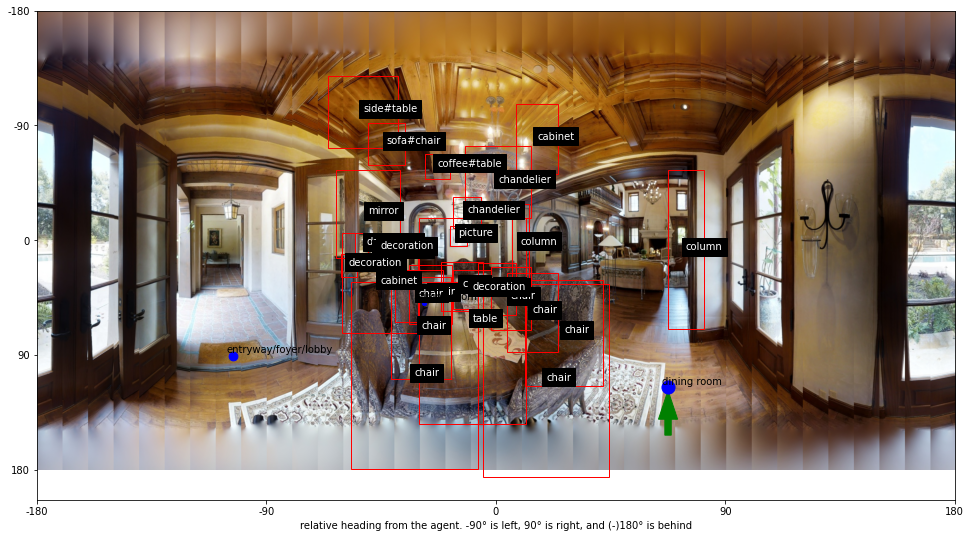

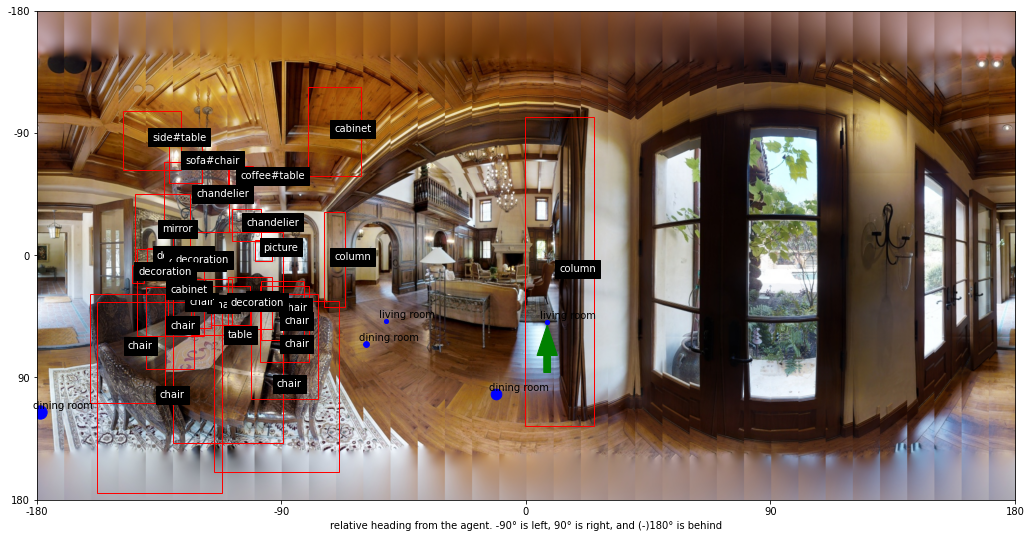

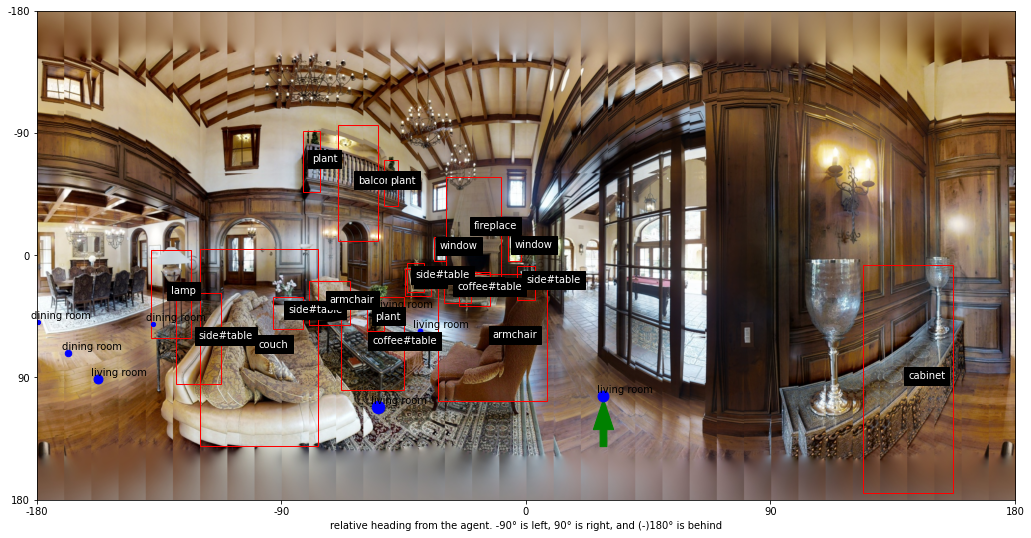

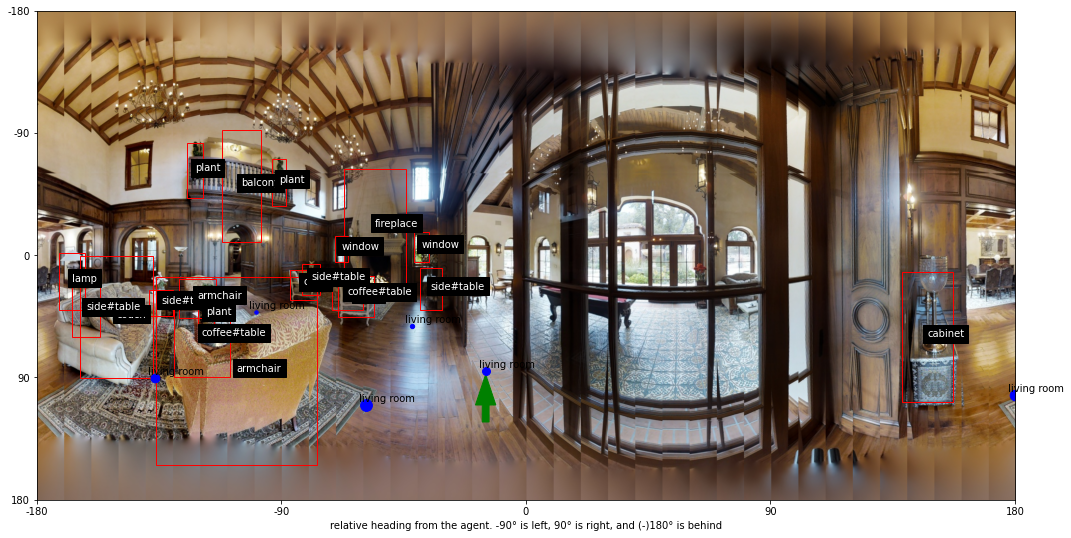

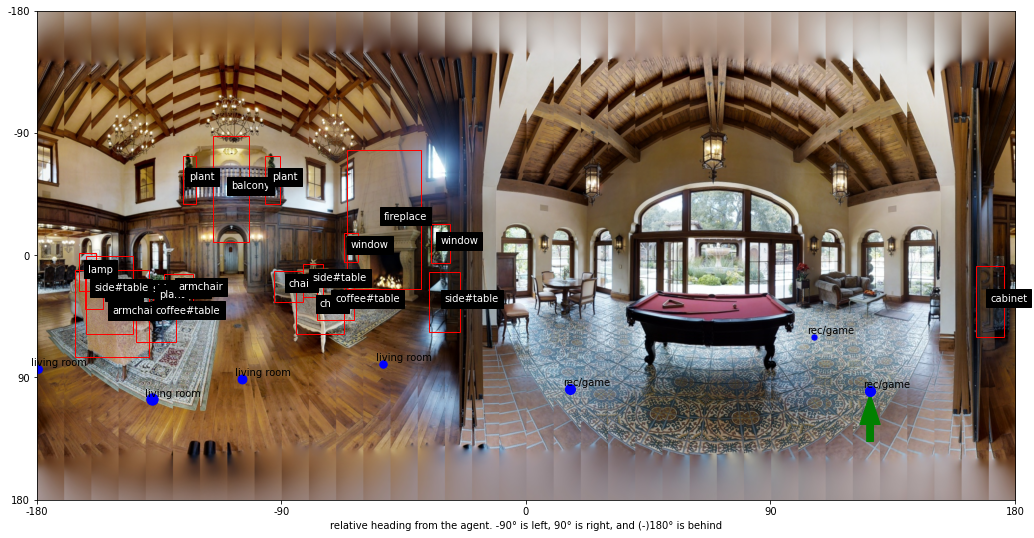

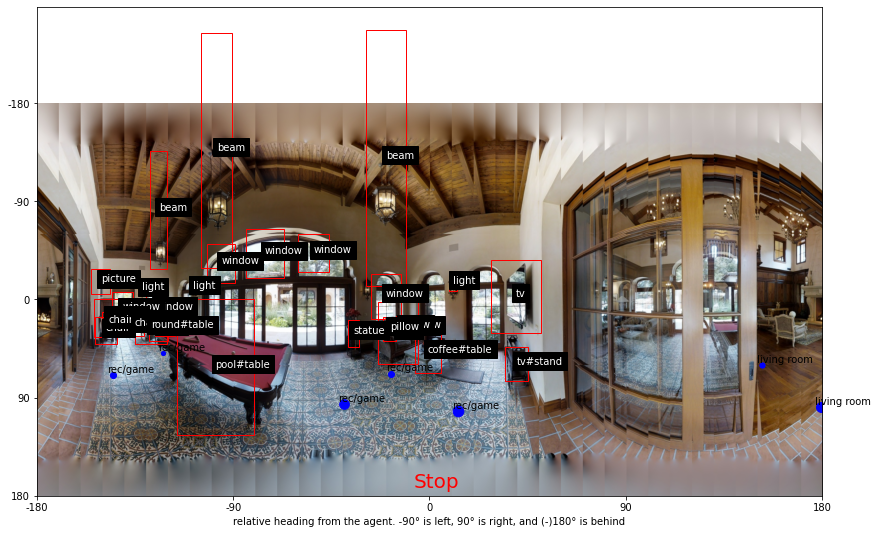

In [155]:
# Instructions
instructions = "- " + "\n\n- ".join(instruction_data['instructions'])
print(instructions)
print("\nAnd new generated instruction:\n")
for idx, model in enumerate(base_models):
    print(f"\n{model}")
    print("- " + new_instructions_by_speaker[idx])

heading = initial_heading
for idx, viewpoint in enumerate(viewpoints_sequence):
    if idx < len(viewpoints_sequence) - 1:
        heading = get_info(scan, viewpoint, heading, viewpoints_sequence[idx + 1], metadata, viewpoints_information)
    else:
        heading = get_info(scan, viewpoint, heading, viewpoints_sequence[idx], metadata, viewpoints_information)
        plt.text(2880 // 2 - 60, 1440 - 30, 'Stop', fontsize=20, color='r') # Stop